# 线性回归章节实践，对应笔记0x03

In [1]:
import math
import time
import numpy as np
import torch
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [2]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

### 正态分布

In [3]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

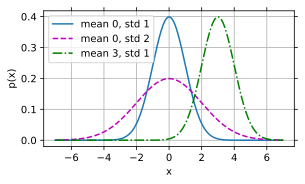

In [4]:
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 线性回归从0实现：

In [5]:
import random

# 生成训练数据
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 正态分布
    y = torch.matmul(X, w) + b # torch.matmul是tensor的乘法，输入可以是高维的。
    # 认为标准假设成立，即服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
# 真正的参数，权重和偏移量
true_w = torch.tensor([2, -3.4])
true_b = 4.2
# 1000个样本
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, features, labels.shape, labels

(torch.Size([1000, 2]),
 tensor([[ 0.9619,  0.5493],
         [-0.9876, -0.6782],
         [-0.6886,  0.3408],
         ...,
         [ 0.5545, -0.0579],
         [-0.6173, -0.3518],
         [-1.3544,  0.3261]]),
 torch.Size([1000, 1]),
 tensor([[ 4.2695e+00],
         [ 4.5242e+00],
         [ 1.6651e+00],
         [ 6.5842e-01],
         [ 6.2154e+00],
         [ 3.7820e+00],
         [ 1.4308e+00],
         [ 2.6163e+00],
         [ 1.0647e+01],
         [ 5.5580e-01],
         [ 1.0188e+01],
         [ 5.4627e+00],
         [ 3.2360e+00],
         [ 3.2881e+00],
         [ 3.4419e+00],
         [ 3.0712e+00],
         [ 1.3547e+00],
         [ 2.3700e+00],
         [ 2.9370e+00],
         [ 2.3267e+00],
         [ 6.1235e-01],
         [-3.8540e+00],
         [ 4.5696e+00],
         [-4.4092e-01],
         [ 6.7533e+00],
         [ 5.2318e-01],
         [ 3.8142e+00],
         [ 5.6406e+00],
         [ 5.2213e+00],
         [ 3.3359e+00],
         [ 1.0119e+00],
         [ 1.4861e

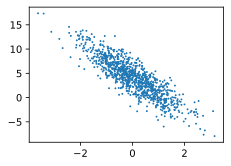

In [6]:
# 通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。
set_figsize()
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据，用于小批量随机梯度下降。
data_iter接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
这个迭代器的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 得到等同样本数量的列表
    indices = list(range(num_examples))
    # 打乱列表顺序
    random.shuffle(indices)
    # 步长为批量大小
    for i in range(0, num_examples, batch_size):
        # 获得批的下标，这里假设样本数能够被批量大小整除，否则会出现最后一批大小小于batch_size的情况
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # yield迭代器，每次产生一批特征和标签。
        yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6736,  1.7347],
        [ 1.5151, -0.2040],
        [-0.1606,  1.0962],
        [ 0.6838,  0.3555],
        [ 0.1478, -0.7870],
        [ 0.9313, -0.4333],
        [ 0.1224, -0.5832],
        [ 0.6109, -1.9067],
        [ 0.5000, -1.0388],
        [-1.6669, -0.6443]]) 
 tensor([[-0.3313],
        [ 7.9259],
        [ 0.1594],
        [ 4.3430],
        [ 7.1808],
        [ 7.5509],
        [ 6.4260],
        [11.9041],
        [ 8.7323],
        [ 3.0665]])


从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。
小批量特征矩阵是（10，2）的，权重是（2，1）的。

In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[ 0.0133],
         [-0.0126]], requires_grad=True),
 tensor([0.], requires_grad=True))

根据线性模型，写出式子。

In [10]:
def linreg(X, w, b):
    """线性回归模型"""
    # matmul就是matrix multiply，矩阵乘法。还有一种就是对应元素相乘，为mul函数。
    return torch.matmul(X, w) + b

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。这里使用平方损失函数。
需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [11]:
def squared_loss(y_hat, y):
    """均方损失，接收的两个参数分别为预测值和真实值"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 #这里除2是对应平方误差计算方式，损失函数求导后系数为1。

优化算法，小批量随机梯度下降。
该函数接受模型参数集合、学习速率和批量大小作为输入。每一步更新的大小由学习速率lr决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。
也就是说，通过除以批量大小来消除批量大小对结果的影响，使得学习速率lr为唯一影响sgd结果的因素。

In [12]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # with 语句适用于对资源进行访问的场合，确保不管使用过程中是否发生异常都会执行必要的“清理”操作，释放资源，比如文件使用后自动关闭／线程中锁的自动获取和释放等。
    # with torch.no_grad()：在该模块下，所有计算得出的tensor的requires_grad都自动设置为False，无论是否指定requires_grad。
    with torch.no_grad():
        for param in params:
            # 由于param会接收列表形式的参数，列表属于可变对象，会采用引用传递的方式，也就是此处的改变会作用到实参上。
            param -= lr * param.grad / batch_size
            # 清除梯度值，只能在梯度值被计算过至少一次后使用。
            param.grad.zero_()

开始训练。在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。
在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.043173
epoch 2, loss 0.000172
epoch 3, loss 0.000051
w的估计误差: tensor([-0.0003, -0.0010], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。 其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 线性回归的框架实现：

In [14]:
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
# 生成训练数据和标签
features, labels = synthetic_data(true_w, true_b, 1000)

调用框架中现有的API来读取数据。 将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。
布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    #把传入的tuple解包作为两个参数输入TensorDataset函数，即特征和标签，需要样本数量对应。
    dataset = data.TensorDataset(*data_arrays)
    # DataLoader本质上就是一个iterable（跟python的内置类型list等一样），并利用多进程来加速batch data的处理，使用yield来使用有限的内存
    # 会将一个数据集（dataset）和一个采样器（sampler）结合。
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 这里顺便学习一下 * 的用法
def d(p1,p2,p3):
    print(p1,p2,p3)
d(1,2,3)
a = (1,2,3)
d(*a)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

1 2 3
1 2 3


iter() 函数用来生成迭代器。
next() 用于返回迭代器的下一个项目。
使用iter构造Python迭代器，并使用next从迭代器中获取第一项。

In [16]:
next(iter(data_iter))

[tensor([[ 0.0446,  0.7251],
         [ 0.6626,  0.6273],
         [ 1.3968, -0.4564],
         [-0.2832, -0.0833],
         [ 0.0742,  1.1793],
         [-0.1790,  0.1394],
         [-1.3452, -0.8742],
         [-0.5679, -1.0045],
         [ 1.4379,  0.4118],
         [-1.0228, -0.1381]]),
 tensor([[1.8243],
         [3.3760],
         [8.5377],
         [3.8937],
         [0.3459],
         [3.3803],
         [4.4925],
         [6.4774],
         [5.6820],
         [2.6167]])]

对于标准深度学习模型，我们可以使用框架的预定义好的层。这使我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。
首先定义一个模型变量net，它是一个Sequential类的实例。 Sequential类将多个层串联在一起。
当给定输入数据时，Sequential实例将数据传入到第一层， 然后将第一层的输出作为第二层的输入，以此类推。
在PyTorch中，全连接层在Linear类中定义。 值得注意的是，我们将两个参数传递到nn.Linear中。
第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [17]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))
# 使用Sequential的多层示例，会按顺序调用层。
# model = nn.Sequential(
#           nn.Conv2d(1,20,5),
#           nn.ReLU(),
#           nn.Conv2d(20,64,5),
#           nn.ReLU()
#         )

在使用net之前，我们需要初始化模型参数。 如在线性回归模型中的权重和偏置。
深度学习框架通常有预定义的方法来初始化参数。 在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，偏置参数将初始化为零。
正如我们在构造nn.Linear时指定输入和输出尺寸一样， 现在我们能直接访问参数以设定它们的初始值。
我们通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值。

In [18]:
# 这里net[0]就是选择第一个层（图层）Linear（2，1）
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

定义损失函数，计算均方误差使用的是MSELoss类，也称为平方L2范数。 默认情况下，它返回所有样本损失的平均值。
定义优化算法，小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。
当我们实例化一个SGD（随机梯度下降）实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。
小批量随机梯度下降只需要设置lr值，这里设置为0.03。
注意这里的超参数字典并不包括迭代周期。

In [19]:
# 这里MSELoss默认的reduction参数为'mean'，即输出的结果为求和后除以样本数。此外还有sum和none可选。如loss = nn.MSELoss(reduction='sum')
loss = nn.MSELoss()
# lr是超参数。
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

在每个迭代周期里，我们将完整遍历一次数据集（train_data）， 不停地从中获取一个小批量的输入和相应的标签。 对于每一个小批量，我们会进行以下步骤:
1. 通过调用net(X)生成预测并计算损失l（前向传播）。
2. 通过进行反向传播来计算梯度。
3. 通过调用优化器来更新模型参数。
下面指定了迭代周期为3，并计算每次迭代后的损失用于监控运行情况。

In [20]:
num_epochs = 3
for epoch in range(num_epochs):
    # 这里是前面读取的数据
    for X, y in data_iter:
        # 注意到这里更加简洁了，参数的初始化被封装在net[0]中了。
        l = loss(net(X) ,y)
        # print(l) #通过打印loss结果测试求和与均值的区别。
        # 清空梯度
        trainer.zero_grad()
        # 由于loss处已经对结果进行了求均值，这里便不用求和直接反向传播即可。
        # 这里有一个疑问，为什么要求均值而不是求和，仅换用求和后，为什么无法优化损失？
        # 答：在之前从零实现时提到过，那时loss计算的损失是一个批量样本的总和，所以用batch_size规范化步长，解耦lr和batch_size。
        #    现在，我们的loss函数默认输出了均值，也就是通过求均值的方式抵消了批量大小对结果的影响，达到解耦目的。
        #    在换用sum前，loss的结果最大值在十位，换用sum后，提升到了百位，正好对应了batch_size=10的情况。可以看出均值抵消了批量大小对优化结果的影响。
        #    但是对于换用求和后如何修改lr的问题，网上有些人说用lr除去batch_size即可，在我的测试下，除去后每个周期损失明显增大，但参数优化结果误差与求均值方法
        #    基本相似。
        l.backward()
        # 利用随机梯度下降执行一次参数优化
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000193
epoch 2, loss 0.000096
epoch 3, loss 0.000096


In [21]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([0.0003, 0.0007])
b的估计误差： tensor([-0.0002])


## 读取图像数据集

In [22]:
import torchvision
from torch.utils import data
from torchvision import transforms

use_svg_display()

# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [23]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [24]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

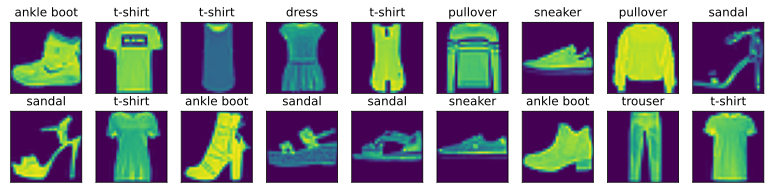

In [25]:
def get_fashion_mnist_labels(labels):
    """
    接收数字形式标签（0-9）
    返回Fashion-MNIST数据集的文本标签
    """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 可视化样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
    绘制图像列表
    参数：
    imgs：图片数据张量
    num_rows：显示行数
    num_cols：显示列数
    titles：图片对应文本标签数组
    scale：缩放比例
    返回：
    一个numpy数组形式的axes列表
    """
    figsize = (num_cols * scale, num_rows * scale)
    # subplots生成一个图形对象和一个axes对象列表，前两个参数是子图列表网格的行数和列数，figsize是图片的大小
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # flatten是把子图列表（一个numpy数组）按行方向降到1维
    axes = axes.flatten()
    # zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的对象
    # 在这里是将子图与对应的图片张量打包，也就是一个subplot对应一个（28，28）的张量
    # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    # 这样最终得到的遍历对象为：索引，（子图，图片）
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        # 判断如果img是张量，则调用imshow函数实现热图绘制，该函数接收的参数为（28，28）张量的numpy数组。
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        # 把子图axes对象的x、y轴设置为不可见
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        # 子图设置title
        if titles:
            ax.set_title(titles[i])
    return axes

# 获取一批训练样本（图片向量，标签）
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

使用内置的数据迭代器多进程读取样本，通过shuffle随机打乱了所有样本，从而无偏见地读取小批量。

In [26]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

# shuffle设为true则每个周期会对数据进行打乱，num_workers为数据读取的子进程数量。
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

timer = Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.46 sec'

In [27]:
def load_data_fashion_mnist(batch_size, resize=None):
    """
    用于获取和读取Fashion-MNIST数据集。
    这个函数返回训练集和验证集的数据迭代器。
    此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。
    """
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

# 测试改变图像大小的功能
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## softmax回归从0实现：

In [28]:
from IPython import display

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

通过把图片向量降维把每个像素位置看作一个特征。
在softmax回归中，我们的输出与类别一样多。
数据集有10个类别，所以网络输出维度为10。
因此，权重将构成一个784x10的矩阵， 偏置将构成一个1x10的行向量。
从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重W，偏置初始化为0。

In [29]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

回顾sum沿着张量中的特定维度的用法
keepdims指定保持在原始张量的轴数，而不折叠求和的维度，对下面的例子来说也就是获得二维张量。

In [30]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

softmax由三个步骤组成：
1. 对每个项求幂（使用exp）；
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
3. 将每一行除以其规范化常数，确保结果的和为1。

In [31]:
def softmax(X):
    X_exp = torch.exp(X)
    # 计算各行（样本）的和
    partition = X_exp.sum(1, keepdim=True)
    # 除以和
    return X_exp / partition  # 这里应用了广播机制

X = torch.normal(0, 1, (2, 5)) # size 2行5列
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1943, 0.0844, 0.1360, 0.5051, 0.0802],
         [0.0715, 0.6836, 0.0704, 0.0536, 0.1209]]),
 tensor([1., 1.]))

上面的函数虽然在数学上看起来是正确的，但在代码实现中有点草率。
矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

net定义了输入如何通过网络映射到输出。
将数据传递到模型之前，使用reshape函数将每张原始图像展平为向量。

In [32]:
def net(X):
    # matmul矩阵乘法，reshape（-1）就是根据另一维度大小自动计算值为-1的维度大小。
    # 偏置b应该应用了广播机制。
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

交叉熵采用真实标签的预测概率的负对数似然。
这里不使用Python的for循环迭代预测（这往往是低效的）， 而是通过一个运算符选择所有元素。
下面将创建一个数据样本y_hat用来代表预测标签，其中包含2个样本在3个类别的预测概率。并创建它们对应的标签y。
有了y，我们知道在第一个样本中，第一类是正确的预测； 而在第二个样本中，第三类是正确的预测。
然后使用y作为y_hat中概率的索引，选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。

In [33]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 这里的张量选择方式比较有意思，根据选择结果我理解是第一个列表表示第一个和第二个样本（也就是行）
# 第二个列表（y）表示该行中第几个元素。
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

实现交叉熵损失函数
$$
l(\mathbf{y}, \hat{\mathbf{y}})=-\sum_{j=1}^{q} \boldsymbol{y}_{j} \log \hat{y}_{j}
$$
按公式看还需要乘一个真实标签，这里好像没有乘不知道为什么

In [34]:
def cross_entropy(y_hat, y):
    print(range(len(y_hat)))
    print(y_hat[range(len(y_hat)), y])
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

range(0, 2)
tensor([0.1000, 0.5000])


tensor([2.3026, 0.6931])

给定预测概率分布y_hat，当必须输出硬预测（hard prediction）时， 通常选择预测概率最高的类。
分类精度即正确预测数量与总预测数量之比。
计算精度需要执行以下操作。
首先，如果y_hat是矩阵，那么假定第二个维度存储每个类的预测分数。
使用argmax获得每行中最大元素的索引来获得预测类别。
然后将预测类别与真实y元素进行比较。 由于等式运算符“==”对数据类型很敏感， 因此需要将y_hat的数据类型转换为与y的数据类型一致。
结果是一个包含0（错）和1（对）的张量。 最后，通过求和得到正确预测的数量。

In [35]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # 这里的 == 也是一个张量运算符，是判断预测与标签是否相同并得到结果张量，如tensor([False,  True])。
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

使用之前定义的变量y_hat和y分别作为预测的概率分布和标签。

In [36]:
accuracy(y_hat, y) / len(y) # 精度，即正确率

0.5

对于任意数据迭代器data_iter可访问的数据集， 我们可以评估在任意模型net的精度。
定义一个实用程序类Accumulator，用于对多个变量进行累加。
在evaluate_accuracy函数中， 在Accumulator实例中创建了2个变量，分别用于存储正确预测的数量和预测的总数量。
当遍历数据集时，两者都将随着时间的推移而累加。

In [37]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    # 判断net是torch神经网络实例
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    # with用法，不计算梯度
    with torch.no_grad():
        for X, y in data_iter:
            # numel获取tensor中一共包含多少个元素
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

由于前面使用随机权重初始化net模型， 因此该模型的精度应接近于随机猜测。 例如在有10个类别情况下的精度为0.1。

In [38]:
evaluate_accuracy(net, test_iter)

0.0986

在开始训练部分的实现之前，定义一个在动画中绘制数据的实用程序类Animator。

In [39]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.clear_output(wait=True)
        display.display(self.fig)

下面开始训练部分。首先，定义一个函数来训练一个迭代周期。
updater是更新模型参数的常用函数，它接受批量大小作为参数。 它可以是d2l.sgd函数，也可以是框架的内置优化函数。

In [40]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 22/5/16：这里有一个问题，为什么使用内置的时候就是求均值，而使用定制优化器则求和？似乎是和线性时同样的问题。
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

接下来实现一个训练函数，它会在train_iter访问到的训练数据集上训练一个模型net。
该训练函数将会运行多个迭代周期（由num_epochs指定）。
在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。
同时该函数还利用Animator类来可视化训练进度。

In [41]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

使用线性回归从零实现中定义的小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。

In [42]:
lr = 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

训练模型10个迭代周期。迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。通过更改它们的值，我们可以提高模型的分类精度。

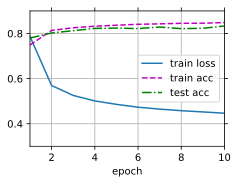

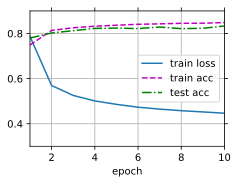

In [43]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

下面开始使用训练好的模型进行预测，给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。

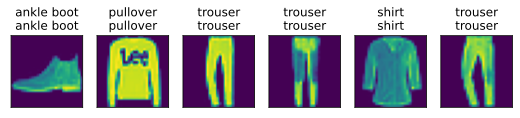

In [44]:
def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## softmax回归的框架实现：

In [45]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

softmax回归的输出层是一个全连接层。
因此只需在Sequential中添加一个带有10个输出的全连接层。
同样，在这里Sequential并不是必要的，但它是实现深度模型的基础。
仍然以均值0和标准差0.01随机初始化权重。
偏置的话因为是0似乎不用特别写代码了。

In [46]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状，此时相当于两层了。
net_torch = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_torch.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

对softmax函数进行了剖析，使用框架自带的交叉熵的话会自动通过LogSumExp防止上下溢出的情况发生。
也就是说nn的交叉熵已经包括了softmax！
下面是损失（交叉熵）和优化算法（学习率为0.1的小批量随机梯度下降）

In [47]:
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net_torch.parameters(), lr=0.1)

net_torch, train_iter, test_iter, loss, num_epochs, trainer

(Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=10, bias=True)
 ),
 CrossEntropyLoss(),
 10,
 SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

下面开炼！

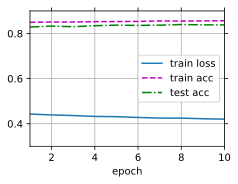

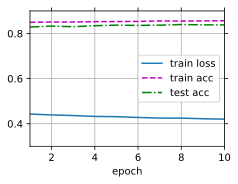

In [49]:
num_epochs = 10
train_ch3(net_torch, train_iter, test_iter, loss, num_epochs, trainer)
# 22/5/16：这里跑不出结果，图像是空白，不知道什么原因。
# 22/5/17：隔了一天又跑出来了！懵。
# 22/5/22：发现了，是Animator add函数中display.clear_output(wait=True)的问题，在pycharm中清除不掉上一次的绘图。修改了一下，变成不是动画了😂。